In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error



# Standard OLS regression

                            OLS Regression Results                            
Dep. Variable:       Mean_Obesity_Pct   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     31.98
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           8.40e-07
Time:                        13:53:50   Log-Likelihood:                -124.88
No. Observations:                  50   AIC:                             253.8
Df Residuals:                      48   BIC:                             257.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4310      3.032      5.089      0.0

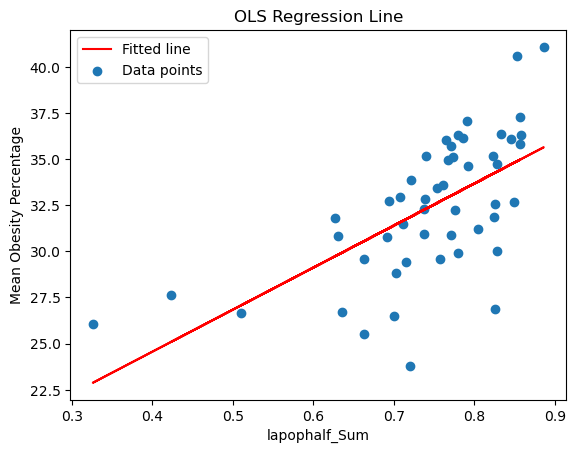

In [22]:
data = pd.read_csv('../data/data-state-for-processing/food_access_state_data_2019.csv')
obesity_data = pd.read_csv('../data/data-state-for-processing/obesity-state-2019-cleaned.csv')
x_var = "lapophalf_Sum"

# align by state
state_code_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DC':'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

obesity_data['LocationAbbr'] = obesity_data['LocationAbbr'].map(state_code_to_name)
merged_data = pd.merge(data, obesity_data, left_on='State', right_on='LocationAbbr')
# print(merged_data['State'])

X = np.divide(merged_data[x_var], merged_data["Pop2010_Sum"])  # Independent variable
# print(X)
Y = merged_data['Mean_Obesity_Pct']  # Dependent variable

# intercept term
X = sm.add_constant(X)

# fit ols
model = sm.OLS(Y, X).fit()

print(model.summary())


# Plot the data points
plt.scatter(np.divide(merged_data[x_var], merged_data["Pop2010_Sum"]), Y, label='Data points')

# Plot the regression line
plt.plot(np.divide(merged_data[x_var], merged_data["Pop2010_Sum"]), model.fittedvalues, color='red', label='Fitted line')

# Add labels and title
plt.xlabel(x_var)
plt.ylabel('Mean Obesity Percentage')
plt.title('OLS Regression Line')
plt.legend()

# Show the plot
plt.show()


# LASSO Regression

## State LASSO Regression

In [3]:
data = pd.read_csv('../data/data-state-for-processing/modified_state_dataset.csv')

# all_variables = [
#     "Urban_Percentage",
#     "Total_Population",
#     "Median_Family_Income",
#     "Population_Half_Percent",
#     "Low_Income_Half_Percent",
#     "Vehicle_Half_Percent",
#     "Population_1_Percent",
#     "Low_Income_1_Percent",
#     "Vehicle_1_Percent",
#     "Mean_Fruit_Consump_Pct",
#     "Mean_Veggie_Consump_Pct",
#     "Convenience stores, 2016",
#     "Farmers' markets, 2018",
#     "Fast-food restaurants, 2016",
#     "Grocery stores, 2016"
# ]

# x_variables = [
#     "Median_Family_Income",
#     "Low_Income_Half_Percent",
#     "Vehicle_Half_Percent",
#     "Low_Income_1_Percent",
#     "Vehicle_1_Percent",
#     "Mean_Fruit_Consump_Pct",
#     "Mean_Veggie_Consump_Pct",
# ]

# Columns to normalize
# columns_to_normalize = [
#     "Convenience stores, 2016",
#     "Farmers' markets, 2018",
#     "Fast-food restaurants, 2016",
#     "Grocery stores, 2016"
# ]

# # Calculate the total number of stores for each row
# data['Total_Stores'] = data[columns_to_normalize].sum(axis=1)

# # Calculate the percentage for each type of store
# data['Convenience_Percent'] = (data["Convenience stores, 2016"] / data['Total_Stores']) * 100
# data['Farmers_Percent'] = (data["Farmers' markets, 2018"] / data['Total_Stores']) * 100
# data['FastFood_Percent'] = (data["Fast-food restaurants, 2016"] / data['Total_Stores']) * 100
# data['Grocery_Percent'] = (data["Grocery stores, 2016"] / data['Total_Stores']) * 100

# # Drop the Total_Stores column if you don't need it anymore
# data = data.drop(columns=['Total_Stores'])



In [21]:
data = pd.read_csv('../data/data-state-for-processing/modified_state_dataset (1).csv')

food_desert_vars = ['Vehicle_Half_Percent', 'Population_Half_Percent', 'Low_Income_Half_Percent',
                    'Population_1_Percent', 'Low_Income_1_Percent', 'Vehicle_1_Percent']
food_swamp_vars = ['Convenience stores, 2016', 'Fast-food restaurants, 2016']
food_heaven_vars = ['Grocery stores, 2016', 'Farmers\' markets, 2018', 'Low_Fruit_Consump_Pct', 'Low_Veggie_Consump_Pct']

var_set = [food_desert_vars, food_swamp_vars, food_heaven_vars]

Alpha: 0.05
                   Feature  Coefficient
0     Vehicle_Half_Percent     1.061420
1  Population_Half_Percent     0.042296
2  Low_Income_Half_Percent     0.530756
3     Population_1_Percent     0.080566
4     Low_Income_1_Percent    -0.426858
5        Vehicle_1_Percent     1.906419
Intercept: 3.0822593723637155


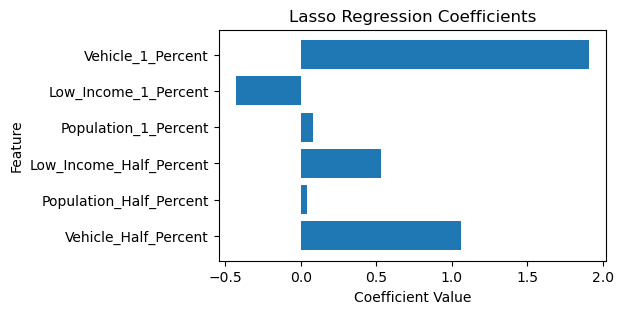

Alpha: 0.05
                       Feature  Coefficient
0     Convenience stores, 2016     1.263400
1  Fast-food restaurants, 2016    -0.746202
Intercept: 3.0822593723637155


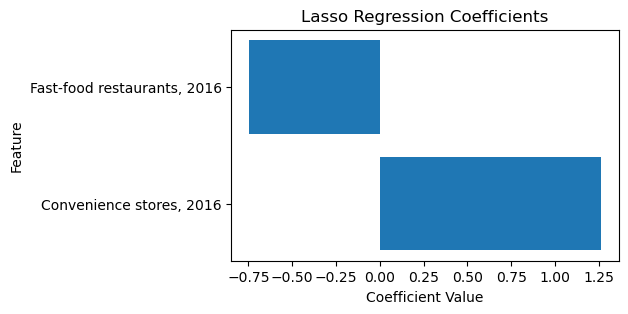

Alpha: 0.05
                  Feature  Coefficient
0    Grocery stores, 2016    -0.366139
1  Farmers' markets, 2018    -0.530112
2   Low_Fruit_Consump_Pct     0.729823
3  Low_Veggie_Consump_Pct    -0.096519
Intercept: 3.0822593723637155


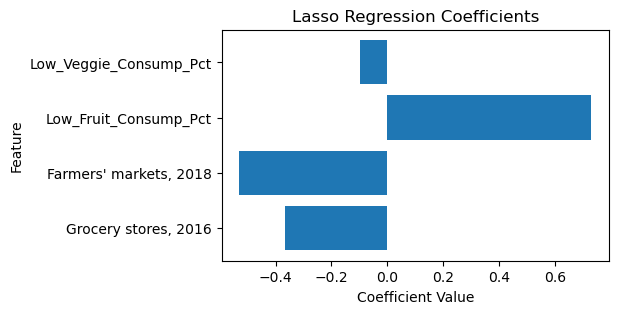

In [20]:
columns_to_scale = [
    "Convenience stores, 2016",
    "Farmers' markets, 2018",
    "Fast-food restaurants, 2016",
    "Grocery stores, 2016"
]
data[columns_to_scale] = data[columns_to_scale] * 100

for x_variables in var_set:
    data = data.dropna(subset=x_variables + ["Mean_Obesity_Pct"])
    
    X, y = data[x_variables], data["Mean_Obesity_Pct"]
    # define model
    alpha = 0.05
    model = Ridge(alpha)
    model.fit(X, y)
    
    # # define model evaluation method
    # cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # # evaluate model
    # scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # # force scores to be positive
    # scores = abs(scores)
    # print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    
    # cross validation to find the best alpha for the model
    # model = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
    # model.fit(X, y)
    
    # alpha = model.alpha_
    coefficients = model.coef_
    # intercept = model.intercept_
    
    coef_df = pd.DataFrame({
        'Feature': x_variables,
        'Coefficient': coefficients
    })
    
    print(f'Alpha: {alpha}')
    print(coef_df)
    print(f'Intercept: {intercept}')
    # plot results

    plt.figure(figsize=(5, 3))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Lasso Regression Coefficients')
    plt.show()


In [103]:
data = pd.read_csv('../data/data-state-for-processing/modified_state_dataset (1).csv')

food_desert_vars = ['Vehicle_Half_Percent', 'Population_Half_Percent', 'Low_Income_Half_Percent',
                    'Population_1_Percent', 'Low_Income_1_Percent', 'Vehicle_1_Percent']
food_swamp_vars = ['Convenience stores, 2016', 'Fast-food restaurants, 2016']
food_heaven_vars = ['Grocery stores, 2016', 'Farmers\' markets, 2018', 'Low_Fruit_Consump_Pct', 'Low_Veggie_Consump_Pct']

var_set = food_desert_vars + food_swamp_vars + food_heaven_vars

columns_to_scale = [
    "Convenience stores, 2016",
    "Farmers' markets, 2018",
    "Fast-food restaurants, 2016",
    "Grocery stores, 2016"
]
data[columns_to_scale] = data[columns_to_scale] * 100

Mean MAE: 2.047 (0.605)
Alpha: 0.1779412316868983
                        Feature  Coefficient
0          Vehicle_Half_Percent     0.996816
1       Population_Half_Percent     0.034722
2       Low_Income_Half_Percent     0.099637
3          Population_1_Percent     0.111665
4          Low_Income_1_Percent    -0.000000
5             Vehicle_1_Percent     0.000000
6      Convenience stores, 2016     0.000000
7   Fast-food restaurants, 2016     0.000000
8          Grocery stores, 2016     0.000000
9        Farmers' markets, 2018    -0.000000
10        Low_Fruit_Consump_Pct     0.225242
11       Low_Veggie_Consump_Pct     0.383384
Intercept: 3.0822593723637155


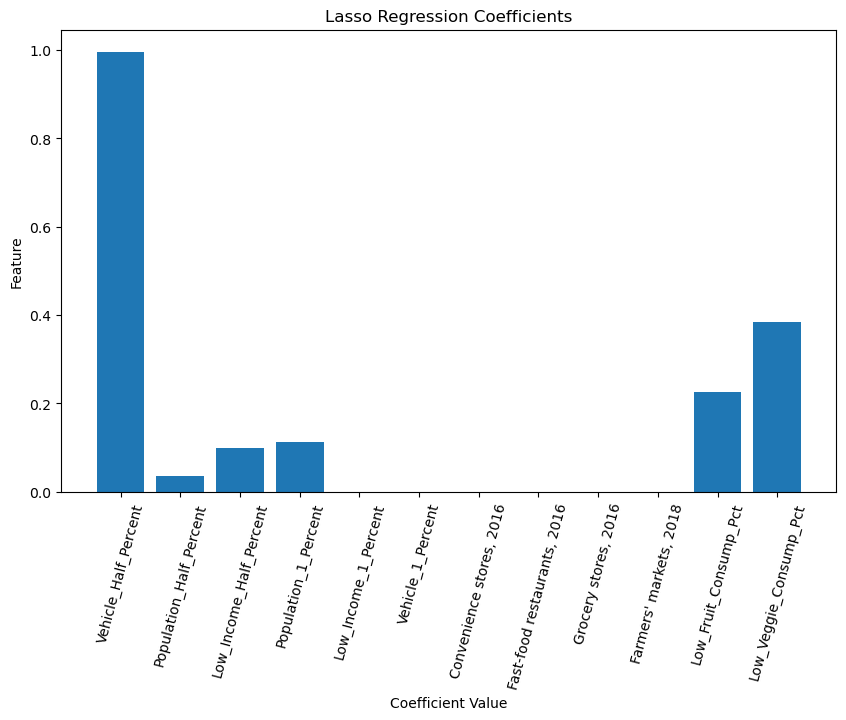

In [106]:
x_variables = var_set
data = data.dropna()

X, y = data[x_variables], data["Mean_Obesity_Pct"]
# define model
# alpha = 1
# model = Ridge(alpha)
# model.fit(X, y)

#cross validation to find the best alpha for the model
model = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
model.fit(X, y)

alpha = model.alpha_
coefficients = model.coef_
# intercept = model.intercept_

coef_df = pd.DataFrame({
    'Feature': x_variables,
    'Coefficient': coefficients
})

print(f'Alpha: {alpha}')
print(coef_df)
print(f'Intercept: {intercept}')
# plot results

plt.figure(figsize=(10, 6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.xticks(rotation=75)
plt.ylabel('Feature')
plt.title('Lasso Regression Coefficients')
plt.show()

## County LASSO Regression

In [88]:
data = pd.read_csv('../data/data-county-for-processing/modified_california_counties.csv')

x_variables = ["Median_Family_Income", "Population_Half_Percent", 
               "Low_Income_Half_Percent", "Vehicle_Half_Percent", "Population_1_Percent", "Low_Income_1_Percent", "Vehicle_1_Percent", 
               "Grocery stores, 2016", "Convenience stores, 2016", "Fast-food restaurants, 2016", "Farmers' markets, 2018", 
               "Veggie", "Veggie Low Income", "Fruit ", "Fruit Low Income", "Fast Food", "Fast Food Low Income", 
               "Soda ", "Soda Low Income"]

columns_to_scale = [
    "Convenience stores, 2016",
    "Farmers' markets, 2018",
    "Fast-food restaurants, 2016",
    "Grocery stores, 2016"
]
data[columns_to_scale] = data[columns_to_scale] * 100

  State     County  Urban_Percentage  Total_Population  Housing_Units  \
0    CA    Alameda         98.333333         1510271.0       545138.0   
1    CA     Alpine          0.000000            1175.0          497.0   
2    CA     Amador          0.000000           38091.0        14569.0   
3    CA      Butte         74.509804          220000.0        87618.0   
4    CA  Calaveras         20.000000           45578.0        18886.0   

   Median_Family_Income  Population_Half_Percent  Low_Income_Half_Percent  \
0         112924.390449                43.817633                 8.587201   
1          82813.000000               100.000000                35.574468   
2          74668.222222                86.653015                21.842430   
3          65078.200000                73.602727                28.130455   
4          74943.444444                87.401817                27.188556   

   Vehicle_Half_Percent  Population_1_Percent  ...  Obese  Obese Low Income  \
0              0.99

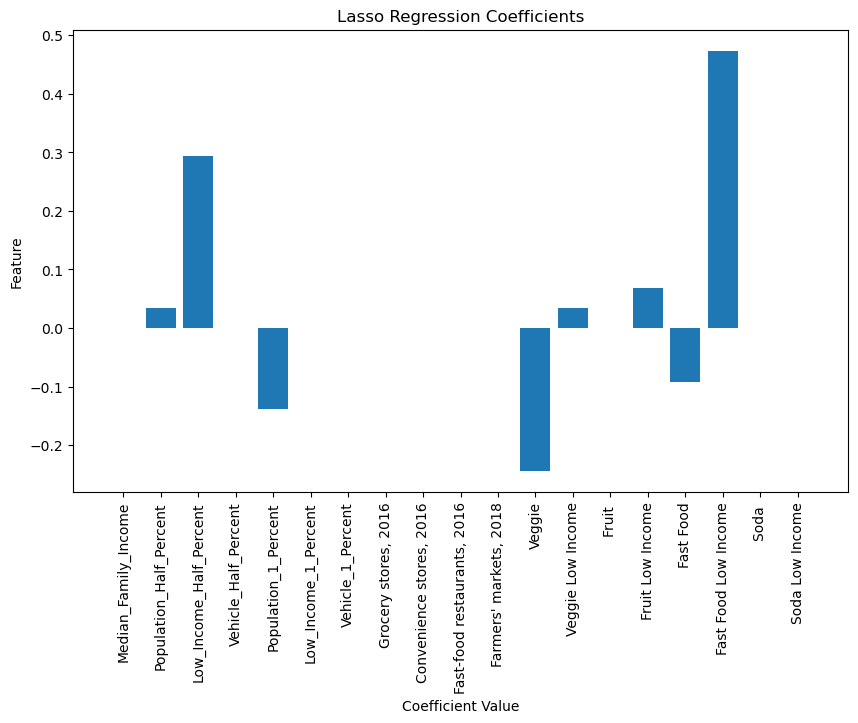

In [89]:
data = data.dropna()
# data = data.drop(columns=["State", "County"])
print(data.head())


X, y = data[x_variables], data["Obese"]
# define model
alpha = 2
model = Lasso(alpha)
model.fit(X, y)

# define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = abs(scores)
# print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# #cross validation to find the best alpha for the model
# model = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
# model.fit(X, y)

# alpha = model.alpha_
coefficients = model.coef_
# intercept = model.intercept_

coef_df = pd.DataFrame({
    'Feature': x_variables,
    'Coefficient': coefficients
})

print(f'Alpha: {alpha}')
print(coef_df)
print(f'Intercept: {intercept}')
# plot results

plt.figure(figsize=(10, 6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.xticks(rotation=90)
plt.ylabel('Feature')
plt.title('Lasso Regression Coefficients')
plt.show()

# Ridge Regression

## State Ridge Regression

In [22]:
data = pd.read_csv('../data/data-state-for-processing/modified_state_dataset (1).csv')

food_desert_vars = ['Vehicle_Half_Percent', 'Population_Half_Percent', 'Low_Income_Half_Percent',
                    'Population_1_Percent', 'Low_Income_1_Percent', 'Vehicle_1_Percent']
food_swamp_vars = ['Convenience stores, 2016', 'Fast-food restaurants, 2016']
food_heaven_vars = ['Grocery stores, 2016', 'Farmers\' markets, 2018', 'Low_Fruit_Consump_Pct', 'Low_Veggie_Consump_Pct']

var_set = food_desert_vars + food_swamp_vars + food_heaven_vars

In [61]:
data = data.dropna()
columns_to_scale = [
    "Convenience stores, 2016",
    "Farmers' markets, 2018",
    "Fast-food restaurants, 2016",
    "Grocery stores, 2016"
]
data[columns_to_scale] = data[columns_to_scale] * 100

# Separate features and target variable
X = data[var_set]
y = data['Mean_Obesity_Pct']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a ridge regression model
ridge = Ridge(alpha=1.0)  # alpha is the regularization parameter lambda
ridge.fit(X, y)

# Make predictions
# y_pred_train = ridge.predict(X_train)
# y_pred_test = ridge.predict(X_test)

# # Calculate mean squared error
# mse_train = mean_squared_error(y_train, y_pred_train)
# mse_test = mean_squared_error(y_test, y_pred_test)

# print("Training MSE:", mse_train)
# print("Testing MSE:", mse_test)

# Optional: Display coefficients
print("Ridge Coefficients:", ridge.coef_)

Ridge Coefficients: [ 1.95414660e+00 -3.61903605e-02  3.37945901e-01  2.53564284e-01
 -4.62752365e-01 -8.25142973e-01  2.83983514e-03 -8.27864894e-04
  3.84403993e-03 -2.00603526e-02  2.69466100e-01  3.95952295e-01]


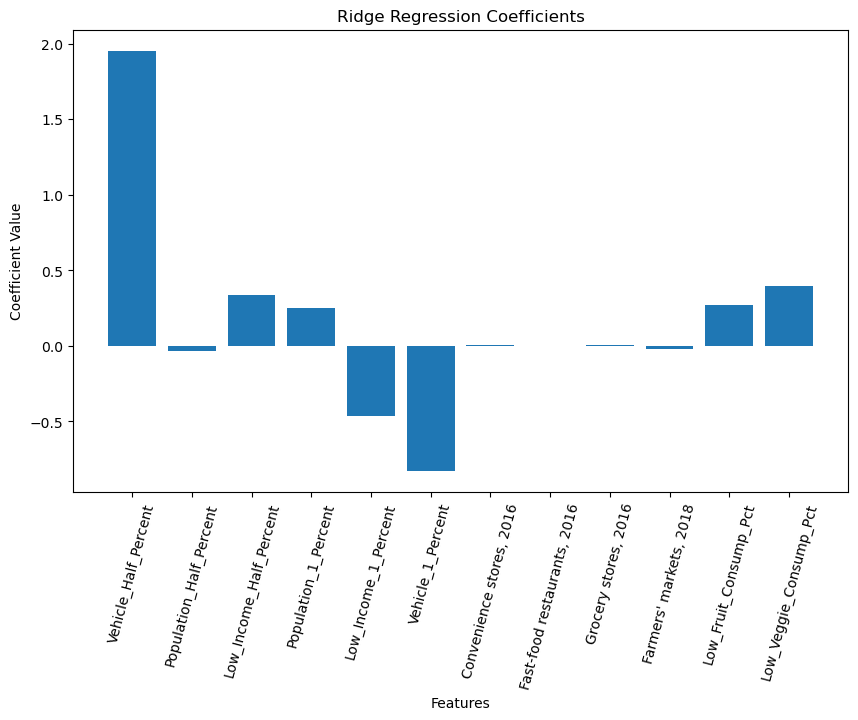

In [62]:
features = X.columns
coefficients = ridge.coef_
plt.figure(figsize=(10, 6))
plt.bar(features, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=75)
plt.title('Ridge Regression Coefficients')
plt.show()

## County Ridge Regression

In [99]:

# Separate features and target variable
X = data[x_variables]
y = data['Obese']

# Train a ridge regression model
ridge = Ridge(alpha=1.0)  # alpha is the regularization parameter lambda
ridge.fit(X, y)

# Optional: Display coefficients
print("Ridge Coefficients:", ridge.coef_)

Ridge Coefficients: [ 1.36142461e-04 -6.27587870e-02  1.91851535e+00 -7.85548042e+00
  1.90146656e-01 -1.86465579e+00  3.59579805e+00 -2.86540073e-01
  5.91169511e-01 -8.99061410e-01 -3.57325497e-01 -8.89471556e-01
  2.97725588e-01 -1.70367134e-01  1.45108169e-01 -5.24059757e-01
  5.52772974e-01  1.24050305e-02 -1.57452642e-01]


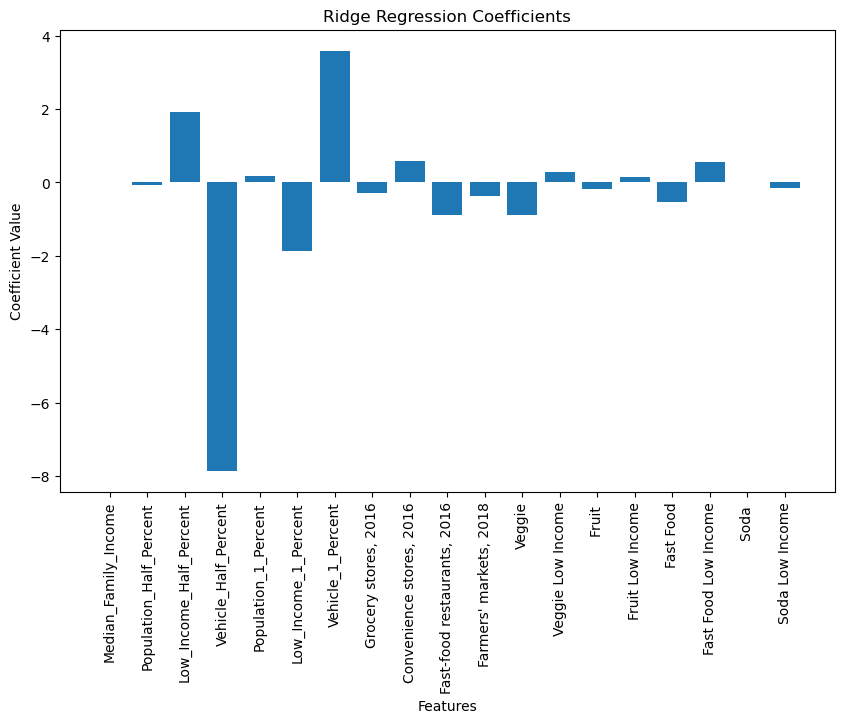

In [100]:
features = X.columns
coefficients = ridge.coef_
plt.figure(figsize=(10, 6))
plt.bar(features, coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.title('Ridge Regression Coefficients')
plt.show()